### 数据集构造逻辑理解

本次实验旨在在增量学习（Incremental Learning）场景中构建一个动态的数据集，基于 CIFAR-10 数据集，通过初始数据集、增量数据集、重放数据集以及噪声处理机制来模拟数据随时间变化的情况。以下是对数据集构造过程的详细理解：

#### 1. 初始数据集划分
- **数据集总量**：CIFAR-10 包含 50,000 个训练样本和 10,000 个测试样本。
- **训练数据集**：记为 $D_{\text{train}} = \{ (x_i, y_i) \mid i = 1, 2, \dots, 50000 \}$，其中 $x_i$ 是图像数据，$y_i$ 是对应的标签。
- **划分方法**：
  - **初始数据集 $D_0$**：从 $D_{\text{train}}$ 中随机抽取 50% 的样本，即 25,000 个样本。
  - **增量数据集 $D_{\text{inc}}$**：剩余的 50% 样本，即 25,000 个样本。

#### 2. 重放数据集 $D_a$
- **构建方式**：从初始数据集 $D_0$ 中随机抽取 10% 的样本，形成重放数据集 $D_a$。
- **样本数量**：$|D_a| = 2,500$。
- **目的**：重放数据集用于在后续的增量学习过程中，帮助模型记忆初始阶段的重要信息，防止遗忘。

#### 3. 增量数据集版本 $D_{\text{inc}}^{(t)}$
增量数据集 $D_{\text{inc}}$ 被划分为多个版本，每个版本代表在不同时间点的增量数据。具体包括以下两个主要步骤：

##### 3.1 模拟遗忘
- **目标类别**：模拟类 [1, 3, 5, 7, 9] 的样本遗忘。
- **保留比例（Retention Ratio）**：设定不同版本的保留比例，以模拟随着时间推移，模型对某些类别记忆的逐渐减弱。
  - **第一个增量版本 $D_{\text{inc}}^{(1)}$**：保留 50% 的样本。
  - **第二个增量版本 $D_{\text{inc}}^{(2)}$**：保留 30% 的样本。
  - **第三个增量版本 $D_{\text{inc}}^{(3)}$**：保留 10% 的样本。
- **实现方式**：每个版本从 $D_{\text{inc}}$ 中随机抽取相应比例的样本，构成 $D_{\text{inc}}^{(t)}$。

##### 3.2 噪声注入
- **目标类别**：模拟类 [0, 2, 4, 6, 8] 的样本噪声。
- **噪声比例**：对于每个增量版本 $D_{\text{inc}}^{(t)}$，对目标类别中 20% 的样本注入噪声。
- **噪声注入过程**：
  - 随机选择 20% 的目标类别样本。
  - 将这些样本的标签随机替换为其他类别标签，增加数据的噪声性，模拟现实中可能存在的数据标签错误或干扰。

#### 4. 组合训练数据集 $D_{\text{tr}}^{(t)}$
- **组合方式**：将重放数据集 $D_a$ 与当前增量版本 $D_{\text{inc}}^{(t)}$ 合并，形成训练数据集 $D_{\text{tr}}^{(t)}$。
- **公式表示**：
  \[
  D_{\text{tr}}^{(t)} = D_a \cup D_{\text{inc}}^{(t)}
  \]
  其中，$D_a$ 保持固定，$D_{\text{inc}}^{(t)}$ 随时间版本的不同而变化。
- **样本数量**：
  - $D_{\text{tr}}^{(1)}$：2,500 + 12,500 = 15,000
  - $D_{\text{tr}}^{(2)}$：2,500 + 7,500 = 10,000
  - $D_{\text{tr}}^{(3)}$：2,500 + 2,500 = 5,000

#### 5. 保存与使用
- **数据保存**：每个版本的训练数据集 $D_{\text{tr}}^{(t)}$ 分别保存为独立的 `.npy` 文件，便于后续的增量学习实验使用。
  - 数据部分：`cifar10_D_tr_data_version_{t}.npy`
  - 标签部分：`cifar10_D_tr_labels_version_{t}.npy`
- **测试数据集**：保持不变，作为模型性能评估的标准。

#### 6. 总结
- **动态性**：每个版本的训练数据集不仅包含固定的重放数据，还包含随时间变化的增量数据，模拟了真实世界中数据不断涌入的情况。
- **挑战性**：通过模拟遗忘和噪声注入，使得模型在学习过程中面临记忆保持和抗噪能力的挑战，有助于评估增量学习算法的鲁棒性和有效性。
- **结构清晰**：数据集构造过程步骤明确，版本划分合理，便于系统化地进行增量学习实验。

### 最终数据集结构
- **重放数据集**：固定的 $D_a$（2,500 个样本）。
- **增量版本数据集**：
  - $D_{\text{tr}}^{(1)} = D_a \cup D_{\text{inc}}^{(1)}$，总计 15,000 个样本（2,500 + 12,500）。
  - $D_{\text{tr}}^{(2)} = D_a \cup D_{\text{inc}}^{(2)}$，总计 10,000 个样本（2,500 + 7,500）。
  - $D_{\text{tr}}^{(3)} = D_a \cup D_{\text{inc}}^{(3)}$，总计 5,000 个样本（2,500 + 2,500）。

每个版本的数据集独立保存为 `.npy` 文件，便于在增量学习过程中按版本加载和使用。

### 关键要点
- **初始与增量划分**：确保初始模型有足够的数据基础，同时为后续增量学习提供持续的数据输入。
- **重放机制**：通过固定的重放数据集，帮助模型在面对新数据时保持对初始数据的记忆，防止灾难性遗忘。
- **模拟遗忘与噪声**：增强数据集的复杂性和现实性，使得增量学习过程更具挑战，评估模型的实际应用能力。
- **版本化管理**：清晰的版本划分和保存机制，便于实验的重复性和结果的对比分析。

通过上述构造逻辑，实验能够有效模拟现实中的增量学习场景，评估模型在面对数据动态变化和噪声干扰时的表现。

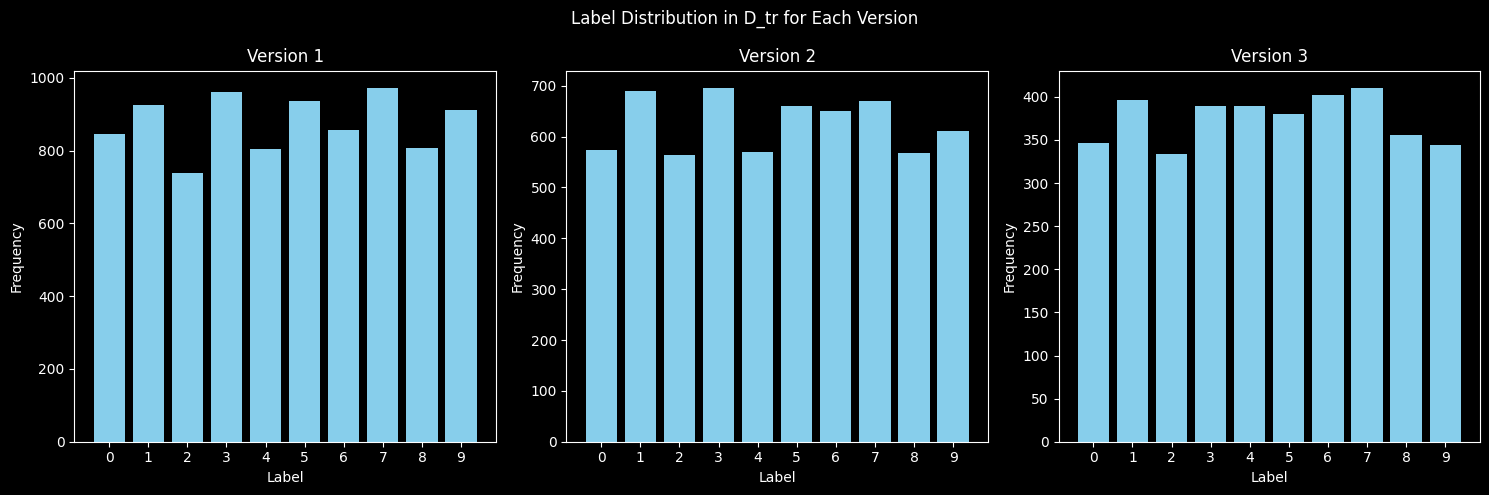

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 定义数据集的路径
base_dir = "../data/cifar-10/noise/"
num_versions = 3  # 假设有3个版本的增量数据集
num_classes = 10  # CIFAR-10 共有10个类

# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version):
    data_path = os.path.join(base_dir, f"cifar10_D_tr_data_version_{version}.npy")
    labels_path = os.path.join(base_dir, f"cifar10_D_tr_labels_version_{version}.npy")
    
    data = np.load(data_path)
    labels = np.load(labels_path)
    
    return data, labels

# 验证每个版本 D_tr 的标签分布变化
def plot_label_distribution():
    fig, axs = plt.subplots(1, num_versions, figsize=(15, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version)

        unique, counts = np.unique(labels, return_counts=True)
        
        # 为了保持 x 轴一致，确保横坐标是从 0 到 9（共10个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值
        
        axs[version - 1].bar(range(num_classes), full_counts, color='skyblue')
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Label")
        axs[version - 1].set_ylabel("Frequency")
        axs[version - 1].set_xticks(range(num_classes))  # 保证横轴一致

    plt.tight_layout()
    plt.show()

# 加载每个版本的 D_tr 并验证其分布
plot_label_distribution()


/tmp/ipykernel_161576/2576557119.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
/tmp/ipykernel_161576/2576557119.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
/tmp/ipykernel_161576/2576557119.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声


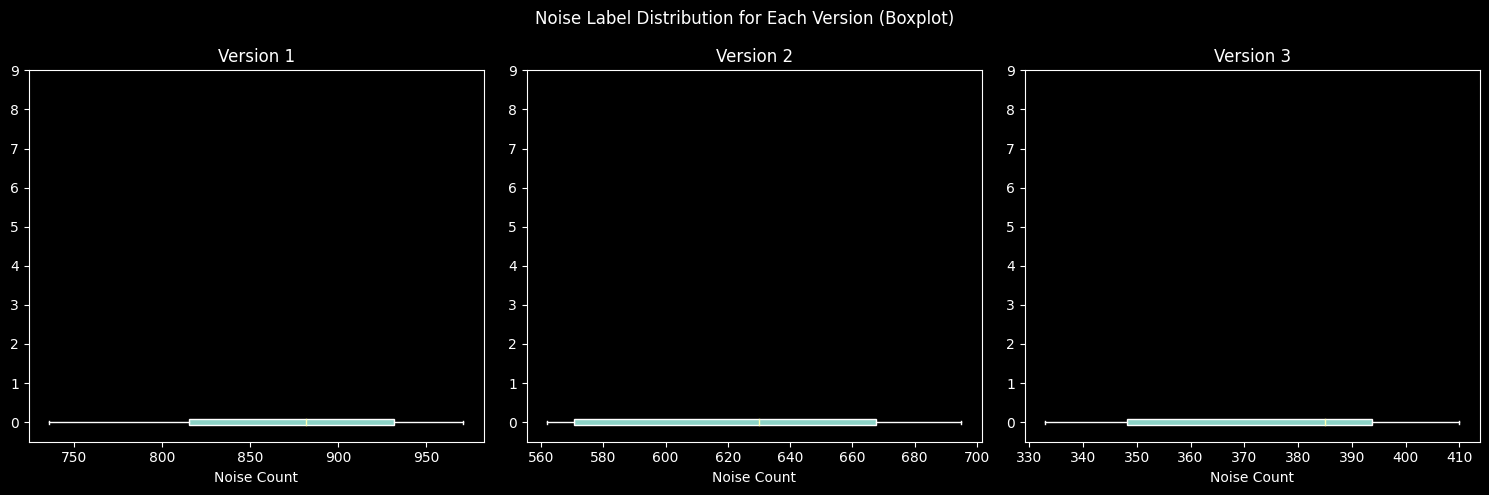

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 定义数据集的路径
base_dir = "../data/cifar-10/noise/"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类

# 加载每个版本的原始标签和噪声标签
def load_labels(version):
    original_labels_path = os.path.join(base_dir, f"D_inc_labels_{version}.npy")
    noisy_labels_path = os.path.join(base_dir, f"cifar10_D_tr_labels_version_{version}.npy")

    original_labels = np.load(original_labels_path)
    noisy_labels = np.load(noisy_labels_path)

    # 由于 D_tr 包含了 D_a 的标签，我们只需要取增量部分的标签
    noisy_labels = noisy_labels[len(original_labels):]  # 切除 D_a 的部分

    return original_labels, noisy_labels

# 计算并可视化噪声标签比例的变化，使用箱线图
def plot_noise_boxplot():
    fig, axs = plt.subplots(1, num_versions, figsize=(15, 5))
    fig.suptitle("Noise Label Distribution for Each Version (Boxplot)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version)

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 计算每个类中的噪声标签数量
        noise_per_class = []
        for label in range(num_classes):
            noise_per_class.append(np.sum(noisy_labels_only == label))

        # 使用箱线图展示噪声标签分布
        axs[version - 1].boxplot(noise_per_class, vert=False, patch_artist=True)
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noise Count")
        axs[version - 1].set_yticks(range(1, num_classes + 1))  # 手动设置 yticks
        axs[version - 1].set_yticklabels(range(num_classes))  # 设置类标签为 0-9

    plt.tight_layout()
    plt.show()

# 验证并使用箱线图可视化各版本中的标签噪声分布
plot_noise_boxplot()


/tmp/ipykernel_161576/2314053936.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声


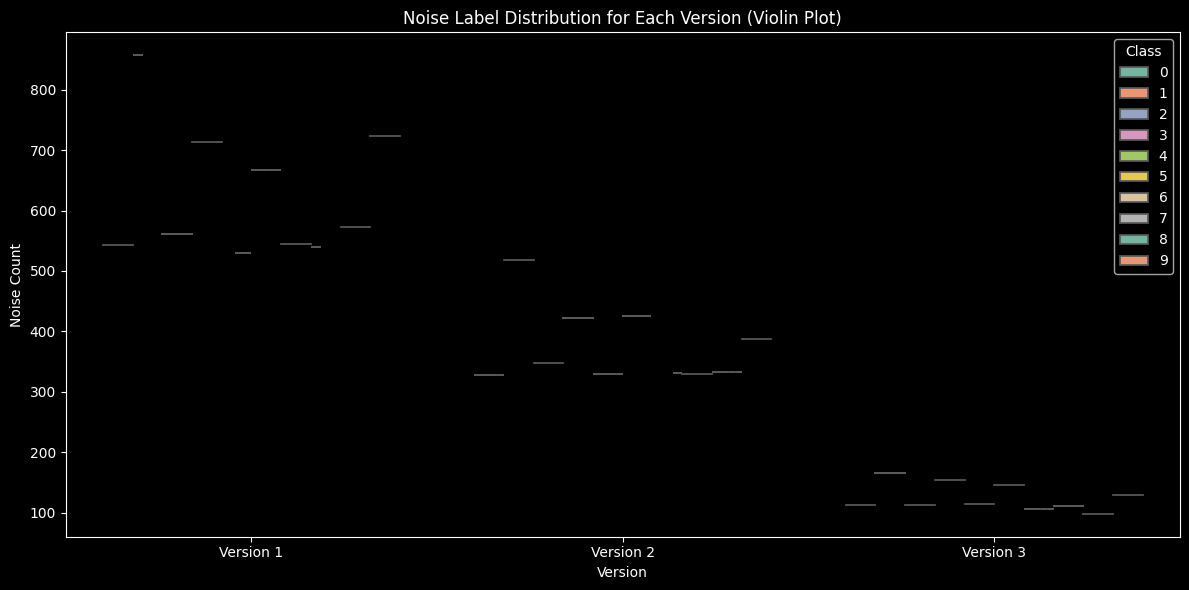

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义数据集的路径
# base_dir = "../data/cifar-10/noise/nr_0.2_nt_symmetric"
base_dir = "../data/cifar-10/noise/nr_0.2_nt_asymmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version):
    original_labels_path = os.path.join(base_dir, f"D_inc_labels_{version}.npy")
    noisy_labels_path = os.path.join(base_dir, f"cifar10_D_tr_labels_version_{version}.npy")

    original_labels = np.load(original_labels_path)
    noisy_labels = np.load(noisy_labels_path)

    # 剔除重放数据 D_a 的标签部分
    noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

    return original_labels, noisy_labels

# 计算并可视化噪声标签比例的变化，使用小提琴图
def plot_noise_violin():
    plt.figure(figsize=(12, 6))  # 设置整体图像大小

    all_noise_data = []
    all_classes = []
    all_versions = []

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version)

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 对于每个类，计算噪声标签的数量并记录
        for label in range(num_classes):
            noise_per_class = np.sum(noisy_labels_only == label)

            # 记录所有噪声数据、对应的类以及版本
            all_noise_data.extend([noise_per_class] * noise_per_class)
            all_classes.extend([label] * noise_per_class)
            all_versions.extend([f"Version {version}"] * noise_per_class)

    # 使用Seaborn的小提琴图进行可视化
    sns.violinplot(x=all_versions, y=all_noise_data, hue=all_classes, split=True, inner="quart", palette="Set2")
    plt.title("Noise Label Distribution for Each Version (Violin Plot)")
    plt.xlabel("Version")
    plt.ylabel("Noise Count")
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()

# 验证并使用小提琴图可视化各版本中的标签噪声分布
plot_noise_violin()
